# Gradient Boosting Regressor

In [38]:
# define load_data
def load_data(tags, start = 'set', end = 'set'):
    
    chw = [string for string in tags if string.endswith("ChilledWater_Demand_kBtu")]
    steam = [string for string in tags if string.endswith("Steam_Demand_kBtu")]
    elec = [string for string in tags if string.endswith("Electricity_Demand_kBtu")]
    
    if (start == 'set') | (end == 'set'):
        if elec:
            elec_years = pd.read_csv('elec_years.csv')
            start = elec_years[elec_years['Electricity_Demand_kBtu'] == tags[0]]['start'].tolist()[0]
            end = elec_years[elec_years['Electricity_Demand_kBtu'] == tags[0]]['end'].tolist()[0]

        if chw:
            chw_years = pd.read_csv('chw_years.csv')
            start = chw_years[chw_years['ChilledWater_Demand_kBtu'] == tags[0]]['start'].tolist()[0]
            end = chw_years[chw_years['ChilledWater_Demand_kBtu'] == tags[0]]['end'].tolist()[0]

        if steam:
            steam_years = pd.read_csv('steam_years.csv')
            start = steam_years[steam_years['Steam_Demand_kBtu'] == tags[0]]['start'].tolist()[0]
            end = steam_years[steam_years['Steam_Demand_kBtu'] == tags[0]]['end'].tolist()[0]
            
    calc = 'summary' 
    interval = '1h'  
    chunk_size = 10
    weight = 'TimeWeighted'
    summary_calc = 'average' 
    max_count = round(1500000/len(tags))

    df = pi.get_stream_by_point(tags, start=start, end=end, _convert_cols=False, calculation=calc, 
                                interval=interval, _weight=weight, _summary_type=summary_calc, _max_count=max_count, 
                                _chunk_size=chunk_size)
    return df


## EDA

In [14]:
# define plot_demand
def plot_demand(tags, title = 'Utility Demand kBtu'):
    
    import matplotlib as mpl
    mpl.style.use('seaborn-whitegrid')
    
    tag = [string for string in tags if string.endswith("_Demand_kBtu")]
        
    plt.figure(figsize = (12,8))
    plt.plot(df[tag], color = '#F18F01', linewidth = 0.5, alpha = 0.7)
    plt.title(title, fontsize = 16)
    plt.xlabel('Dates', fontsize = 12)
    plt.ylabel('Demand kBtu', fontsize = 12)


## Prep data

In [15]:
# prep dataframe
# Account for the case of each utility
def prep_df(df):
    chw = [string for string in df.columns if string.endswith("ChilledWater_Demand_kBtu")]
    steam = [string for string in df.columns if string.endswith("Steam_Demand_kBtu")]
    elec = [string for string in df.columns if string.endswith("Electricity_Demand_kBtu")]
    
    #add outside temp
    tag = pi.search_by_point(['aiTIT4045'])
    start = df.index[0]
    end = df.index[-1]
    calc = 'summary' 
    interval = '1h'   
    chunk_size = 10
    weight = 'TimeWeighted'
    summary_calc = 'average' 
    max_count = round(1500000/len(tag))

    temp = pi.get_stream_by_point(tag, start=start, end=end, _convert_cols=False, calculation=calc, 
                                interval=interval, _weight=weight, _summary_type=summary_calc, _max_count=max_count, 
                                _chunk_size=chunk_size)

    df['aiTIT4045'] = temp.aiTIT4045
    
    #add Holidays
    tag = pi.search_by_point(['ACE_Holidays_Boolean'])
    start = df.index[0]
    end = df.index[-1]
    calc = 'summary' 
    interval = '1h'   
    chunk_size = 10
    weight = 'TimeWeighted'
    summary_calc = 'average' 
    max_count = round(1500000/len(tag))

    hol = pi.get_stream_by_point(tag, start=start, end=end, _convert_cols=False, calculation=calc, 
                                interval=interval, _weight=weight, _summary_type=summary_calc, _max_count=max_count, 
                                _chunk_size=chunk_size)

    df['Holiday'] = hol.ACE_Holidays_Boolean
    
    #add hour
    df.reset_index(inplace=True)
    df['Hour'] = pd.to_datetime(df['Timestamp']).apply(lambda x: '{hour}'.format(hour = x.hour))
    df['Hour'] = df['Hour'].astype('int64') 
    
    
    if chw:
        #add HDH
        df['HDH'] = 65 - df['aiTIT4045']
        df.loc[df['HDH'] < 0, 'HDH'] = 0

        #add CDH
        df['CDH'] = (df['aiTIT4045'] - 65)**2
        df.loc[df['CDH'] < 0, 'CDH'] = 0
        
        #add month
        df['Month'] = pd.to_datetime(df['Timestamp']).apply(lambda x: '{month}'.format(month = x.month))
        df['Month'] = df['Month'].astype('int64')
                                       
    if steam:
        #add HDH
        df['HDH'] = (65 - df['aiTIT4045'])**2
        df.loc[df['HDH'] < 0, 'HDH'] = 0
        
        #add CDH
        df['CDH'] = df['aiTIT4045'] - 65
        df.loc[df['CDH'] < 0, 'CDH'] = 0
        
        #add day of the week
        df['DayOfWeek'] = df['Timestamp'].dt.strftime('%w')
        df['DayOfWeek'] = df['DayOfWeek'].astype('int64')
        df['Weekend'] = 0
        df.loc[(df['DayOfWeek'] == 0) | (df['DayOfWeek'] == 6), 'Weekend'] = 1
        df.loc[(df['DayOfWeek'] == 1) | (df['DayOfWeek'] == 2) | (df['DayOfWeek'] == 3) | (df['DayOfWeek'] == 4) | (df['DayOfWeek'] == 5), 'Weekend'] = 0
        df.drop(['DayOfWeek'], inplace = True, axis = 1)
                                       
        #add month
        #df.reset_index(inplace=True)
        df['Month'] = pd.to_datetime(df['Timestamp']).apply(lambda x: '{month}'.format(month = x.month)) 
        df['Month'] = df['Month'].astype('int64')                                
                                       
    if elec:
        #add HDH
        df['HDH'] = 65 - df['aiTIT4045']
        df.loc[df['HDH'] < 0, 'HDH'] = 0
        
        #add CDH
        df['CDH'] = df['aiTIT4045'] - 65
        df.loc[df['CDH'] < 0, 'CDH'] = 0
            
        # add WiFi
        wifi_matched_tags = pd.read_csv('wifi_matched_tags.csv')
        
        wifi_tag = wifi_matched_tags[wifi_matched_tags['Electricity_Tag'] == elec[0]]['Wi-Fi Tags'].to_list()
        
        df.set_index('Timestamp',inplace=True)
        start = df.index[0]
        end = df.index[-1]
        calc = 'summary' 
        interval = '1h'   
        chunk_size = 10
        weight = 'TimeWeighted'
        summary_calc = 'average' 
        max_count = round(1500000/len(wifi_tag))

        wifi = pi.get_stream_by_point(wifi_tag, start=start, end=end, _convert_cols=False, calculation=calc, 
                                    interval=interval, _weight=weight, _summary_type=summary_calc, _max_count=max_count, 
                                    _chunk_size=chunk_size)
        
        if len(wifi_tag) > 1:
            col = np.zeros(len(wifi))
            for i in wifi_tag:
                col = wifi[i] + col
            df['Wifi_Occupancy_Count'] = col
        else:
            df['Wifi_Occupancy_Count'] = wifi[[wifi_tag[0]]]
            
        df.reset_index(inplace = True)
        
    return df                              
                                       
        

## Cleaning data

In [16]:
# cleaning data function
# add contition to check for quality of data. Too many missing values or zeros? If so return something to prompt main function to switch years
def clean_data(df):
    demand = [string for string in df.columns if string.endswith("_Demand_kBtu")]
    df = df[df[demand[0]] > 0]
    df = df[(df['aiTIT4045'] > 0) & (df['aiTIT4045'] < 120)]
    steam = [string for string in df.columns if string.endswith("Steam_Demand_kBtu")]

    if steam: 
        df = df[df[steam[0]] < 6500]

    df.dropna(axis=0, inplace=True)
    df.set_index('Timestamp',inplace = True)

    if [string for string in df.columns if string.endswith("Electricity_Demand_kBtu")]:
        wifi = [string for string in df.columns if string.endswith("_Count")]
        df_out = df[[demand[0], 'aiTIT4045', wifi[0]]].copy()

    else:
        df_out = df[[demand[0], 'aiTIT4045']].copy()

    IQR = df_out.quantile(0.75) - df_out.quantile(0.25)
    df_final = df_out[~((df_out < (df_out.quantile(0.25) - 3 * IQR)) | (df_out > (df_out.quantile(0.75) + 3 * IQR)))]

    df_final.dropna(axis=0, inplace=True)

    df_final.reset_index(inplace=True)
    df = df.loc[df_final['Timestamp']]
    df.reset_index(inplace = True)

    df.drop(['aiTIT4045'], inplace=True, axis=1)
        
    return df 
      

## Split

In [17]:
# define split function
def split_data(df):
    from sklearn.model_selection import train_test_split 
    demand = [string for string in df.columns if string.endswith("_Demand_kBtu")]
    
    x = df.drop(demand, axis = 1)
    y = df[demand].values.reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, shuffle = False)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, shuffle = False)
    
    dates_train = X_train['Timestamp']
    dates_test = X_test['Timestamp']
    dates_val = X_val['Timestamp']
    X_train.drop('Timestamp', axis = 1, inplace = True)
    X_test.drop('Timestamp', axis = 1, inplace = True)
    X_val.drop('Timestamp', axis = 1, inplace = True)
    
    return X_train, X_test, X_val, y_train, y_test, y_val, dates_train, dates_test, dates_val    
    

## Model

In [18]:
#define model building function
def get_predictions(X_train, X_test, X_val, y_train, y_test, y_val):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import RandomizedSearchCV
    
    param_grid = {'criterion':['friedman_mse', 'mse'], 'loss':['ls','lad'],'learning_rate':[0.1,0.01, 0.001, 0.05],                               
                  'n_estimators':np.linspace(10, 200).astype(int), 'random_state':[1], 'min_samples_split': [2, 5, 10],
                 'max_depth': [None] + list(np.linspace(3, 20).astype(int)), 'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int))}

    estimator = GradientBoostingRegressor()

    rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                            scoring = 'neg_root_mean_squared_error', cv = 5, 
                            n_iter = 10, verbose = 1)
    rs.fit(X_train, y_train)
    
    parameters = rs.best_params_
    
    model = GradientBoostingRegressor(**parameters)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    pred_val = model.predict(X_val)
    
    from sklearn import metrics
    from statistics import mean
    
    #train
    mse_train = metrics.mean_squared_error(y_train, pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    mae_train = metrics.mean_absolute_error(y_train, pred_train)
    cv_rmse_train = rmse_train / mean(y_train.flatten())
    r2_train = metrics.r2_score(y_train, pred_train)

    #test
    mse_test = metrics.mean_squared_error(y_test, pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    mae_test = metrics.mean_absolute_error(y_test, pred_test)
    cv_rmse_test = rmse_test / mean(y_test.flatten())
    r2_test = metrics.r2_score(y_test, pred_test)

    #val
    mse_val = metrics.mean_squared_error(y_val, pred_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, pred_val))
    mae_val = metrics.mean_absolute_error(y_val, pred_val)
    cv_rmse_val = rmse_val / mean(y_val.flatten())
    r2_val = metrics.r2_score(y_val, pred_val)
    
    results = pd.DataFrame(np.array([['MSE', mse_train, mse_test, mse_val], ['RMSE', rmse_train, rmse_test, rmse_val], ['MAE', mae_train, mae_test, mae_val], ['CV(RMSE)', cv_rmse_train, cv_rmse_test, cv_rmse_val], ['R-squared', r2_train, r2_test, r2_val]]), columns=['Measure', 'Train', 'Test', 'Val'])

    return pred_train, pred_test, pred_val, results


## Show results

In [19]:
# visualize predictions
def show_predictions(y_train, y_test, y_val, pred_train, pred_test, pred_val, dates_train, dates_test, dates_val):
    
    from sklearn import metrics
    from statistics import mean
    
    #train
    mse_train = metrics.mean_squared_error(y_train, pred_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, pred_train))
    mae_train = metrics.mean_absolute_error(y_train, pred_train)
    cv_rmse_train = rmse_train / mean(y_train.flatten())
    r2_train = metrics.r2_score(y_train, pred_train)

    #test
    mse_test = metrics.mean_squared_error(y_test, pred_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, pred_test))
    mae_test = metrics.mean_absolute_error(y_test, pred_test)
    cv_rmse_test = rmse_test / mean(y_test.flatten())
    r2_test = metrics.r2_score(y_test, pred_test)

    #val
    mse_val = metrics.mean_squared_error(y_val, pred_val)
    rmse_val = np.sqrt(metrics.mean_squared_error(y_val, pred_val))
    mae_val = metrics.mean_absolute_error(y_val, pred_val)
    cv_rmse_val = rmse_val / mean(y_val.flatten())
    r2_val = metrics.r2_score(y_val, pred_val)
    
    import matplotlib as mpl
    mpl.style.use('seaborn-whitegrid')
    
    plt.figure(figsize = (12, 30))
    
    plt.subplot(3,1,1)
    plt.plot(dates_train, y_train, color='#F18F01', linewidth=0.5, alpha = 0.7)
    plt.plot(dates_train, pred_train, color='#006E90', linewidth=0.5, alpha = 0.9)

    plt.title(f'GradientBoostingRegressor: Predicted vs True Values \n Training Data \n MSE: {round(mse_train, 4)}     MAE: {round(mae_train,4)}    RMSE: {round(rmse_train, 4)}  \n CV(RMSE): {round(cv_rmse_train, 4)}     R2:{round(r2_train,4)}', fontsize = 16)
    plt.xlabel('Dates', fontsize = 12)
    plt.ylabel('Demand kBtu', fontsize = 12)

    leg = plt.legend(labels = ['True','Predicted'], loc = "upper right", bbox_to_anchor=(1.2, 1), fontsize = 12)

    for line in leg.get_lines():
        line.set_linewidth(5.0)

    plt.subplot(3,1,2)
    plt.plot(dates_test, y_test, color='#F18F01', linewidth=0.5, alpha = 0.7)
    plt.plot(dates_test, pred_test, color='#006E90', linewidth=0.5, alpha = 0.9)

    plt.title(f'Testing Data \n MSE: {round(mse_test, 4)}     MAE: {round(mae_test,4)}    RMSE: {round(rmse_test, 4)} \n CV(RMSE): {round(cv_rmse_test, 4)}    R2:{round(r2_test,4)}', fontsize = 16)
    plt.xlabel('Dates', fontsize = 12)
    plt.ylabel('Demand kBtu', fontsize = 12)

    leg = plt.legend(labels = ['True','Predicted'], loc = "upper right", bbox_to_anchor=(1.2, 1), fontsize = 12)

    for line in leg.get_lines():
        line.set_linewidth(5.0)
        
    plt.subplot(3,1,3)
    plt.plot(dates_val, y_val, color='#F18F01', linewidth=0.5, alpha = 0.7)
    plt.plot(dates_val, pred_val, color='#006E90', linewidth=0.5, alpha = 0.9)

    plt.title(f'Validation Data \n MSE: {round(mse_val, 4)}     MAE: {round(mae_val,4)}     RMSE: {round(rmse_val, 4)} \n CV(RMSE): {round(cv_rmse_val, 4)}     R2:{round(r2_val,4)}', fontsize = 16)
    plt.xlabel('Dates', fontsize = 12)
    plt.ylabel('Demand kBtu', fontsize = 12)


    leg = plt.legend(labels = ['True','Predicted'], loc = "upper right", bbox_to_anchor=(1.2, 1), fontsize = 12)

    for line in leg.get_lines():
        line.set_linewidth(5.0)



# Implementation

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ecotools.pi_client import pi_client

sns.set('paper')
# Option Paramater time_zone
# default timezone is time_zone='America/Los_Angeles' use https://www.iana.org/time-zones 

#pi = pi_client(username= r'ad3\username')
pi = pi_client(username = r'ad3\dlrueda')

ad3\dlrueda, please provide your password (text will be hidden) 
>>········
save password? [y/n] /n after saving, set username = 'file' to use this feature 
>>n


In [20]:
tags = pi.search_by_point(['Chemistry_Electricity_Demand_kBtu'])

tags

['Chemistry_Electricity_Demand_kBtu']

In [39]:
df = load_data(tags)
df.head()

14:32:27: Sending API request... Chunk 1 of 1
14:32:28: Response recieved for 1 tags! (1.28)


,Chemistry_Electricity_Demand_kBtu
Timestamp,
2018-09-01 00:00:00,1437.140951
2018-09-01 01:00:00,1428.871455
2018-09-01 02:00:00,1437.313044
2018-09-01 03:00:00,1427.767949
2018-09-01 04:00:00,1426.434026


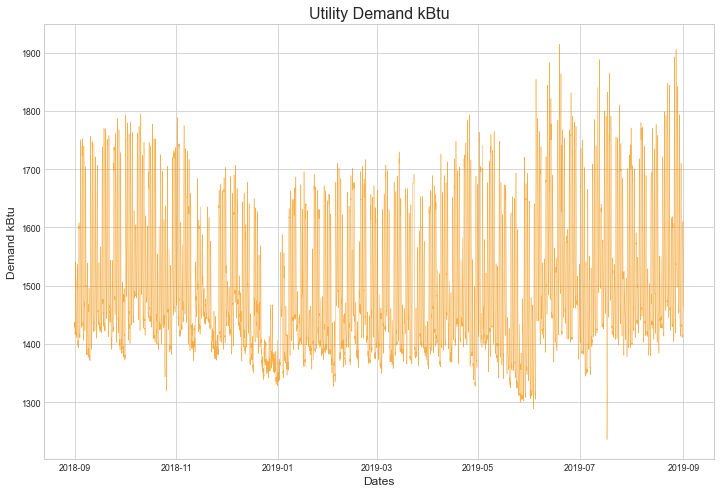

In [40]:
plot_demand(tags)

In [141]:
df = prep_df(df)
df.head()

19:21:10: Sending API request... Chunk 1 of 1
19:21:12: Response recieved for 1 tags! (1.75)
19:21:12: Sending API request... Chunk 1 of 1
19:21:13: Response recieved for 1 tags! (0.51)
19:21:13: Sending API request... Chunk 1 of 1
19:21:14: Response recieved for 1 tags! (1.19)


,Timestamp,Chemistry_Electricity_Demand_kBtu,aiTIT4045,Holiday,Hour,HDH,CDH,Wifi_Occupancy_Count
0,2018-09-01 00:00:00,1437.140951,67.071167,1.0,0,0.000000,2.071167,29.334061
1,2018-09-01 01:00:00,1428.871455,65.564086,1.0,1,0.000000,0.564086,29.832719
2,2018-09-01 02:00:00,1437.313044,64.364953,1.0,2,0.635047,0.000000,29.073026
3,2018-09-01 03:00:00,1427.767949,64.004323,1.0,3,0.995677,0.000000,29.166666
4,2018-09-01 04:00:00,1426.434026,63.287432,1.0,4,1.712568,0.000000,29.000000


In [142]:
df = clean_data(df)
df.head()

,Timestamp,Chemistry_Electricity_Demand_kBtu,Holiday,Hour,HDH,CDH,Wifi_Occupancy_Count
0,2018-09-01 00:00:00,1437.140951,1.0,0,0.000000,2.071167,29.334061
1,2018-09-01 01:00:00,1428.871455,1.0,1,0.000000,0.564086,29.832719
2,2018-09-01 02:00:00,1437.313044,1.0,2,0.635047,0.000000,29.073026
3,2018-09-01 03:00:00,1427.767949,1.0,3,0.995677,0.000000,29.166666
4,2018-09-01 04:00:00,1426.434026,1.0,4,1.712568,0.000000,29.000000


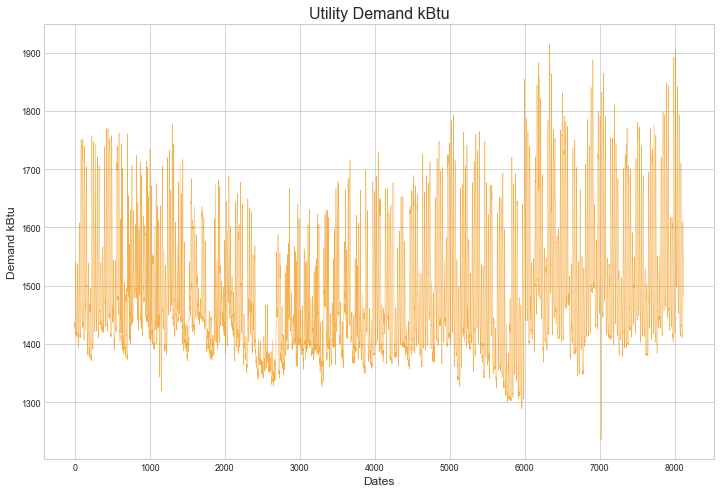

In [143]:
plot_demand(tags)

In [144]:
X_train, X_test, X_val, y_train, y_test, y_val, dates_train, dates_test, dates_val = split_data(df)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [145]:
pred_train, pred_test, pred_val, results = get_predictions(X_train, X_test, X_val, y_train, y_test, y_val)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [146]:
results

,Measure,Train,Test,Val
0,MSE,2091.6622969690884,1064.7816478312513,2167.875218634287
1,RMSE,45.73469467449289,32.630992136790006,46.56044693336059
2,MAE,31.565564543079947,25.90567483296446,34.81786511506173
3,CV(RMSE),0.030878564227747447,0.021385003302766322,0.029922750699839157
4,R-squared,0.8225897603002839,0.9188475790802402,0.8765261491045058


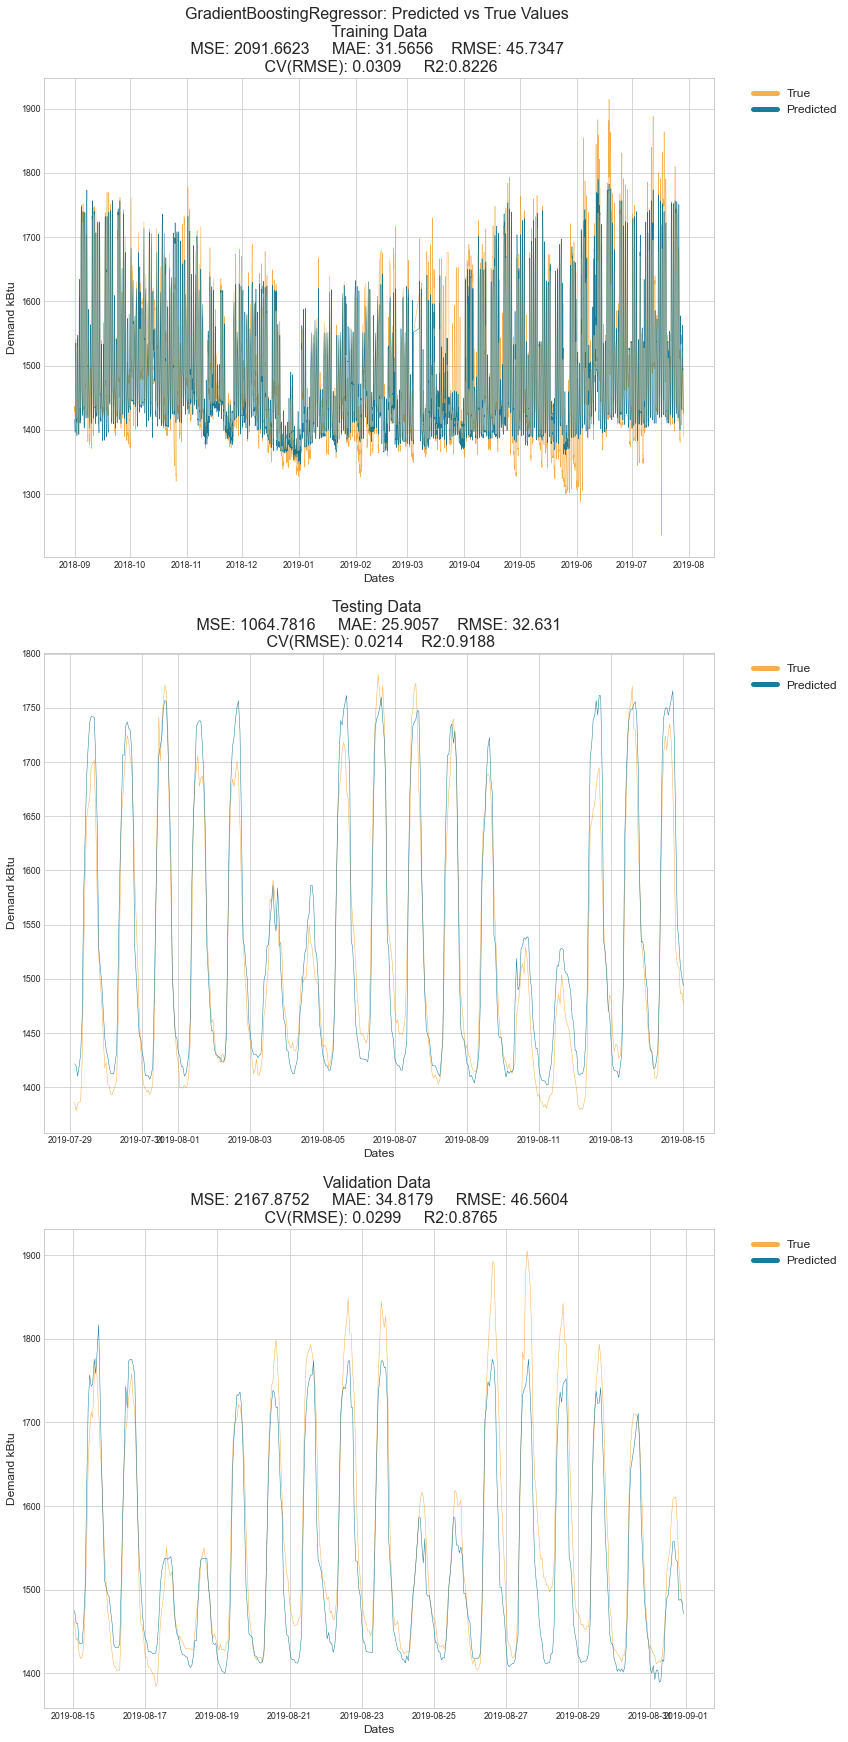

In [147]:
show_predictions(y_train, y_test, y_val, pred_train, pred_test, pred_val, dates_train, dates_test, dates_val)


# Putting it together

In [57]:
def demandkBtu_model(tags):
    elec_years = pd.read_csv('elec_years.csv')
    chw_years = pd.read_csv('chw_years.csv')
    steam_years = pd.read_csv('steam_years.csv')
    possible_tags = elec_years['Electricity_Demand_kBtu'].tolist() + chw_years['ChilledWater_Demand_kBtu'].tolist() + steam_years['Steam_Demand_kBtu'].tolist()
    
    if tags[0] not in possible_tags:
        return print('This tag contains unreliable data')# which tag failed?
    
    df = clean_data(prep_df(load_data(tags)))
    
    X_train, X_test, X_val, y_train, y_test, y_val, dates_train, dates_test, dates_val = split_data(df)
    
    pred_train, pred_test, pred_val, results = get_predictions(X_train, X_test, X_val, y_train, y_test, y_val)
    
    show_predictions(y_train, y_test, y_val, pred_train, pred_test, pred_val, dates_train, dates_test, dates_val)
    
    

14:40:38: Sending API request... Chunk 1 of 1
14:40:38: Response recieved for 1 tags! (0.65)
14:40:38: Sending API request... Chunk 1 of 1
14:40:40: Response recieved for 1 tags! (1.77)
14:40:41: Sending API request... Chunk 1 of 1
14:40:41: Response recieved for 1 tags! (0.46)
14:40:42: Sending API request... Chunk 1 of 1
14:40:43: Response recieved for 1 tags! (1.08)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


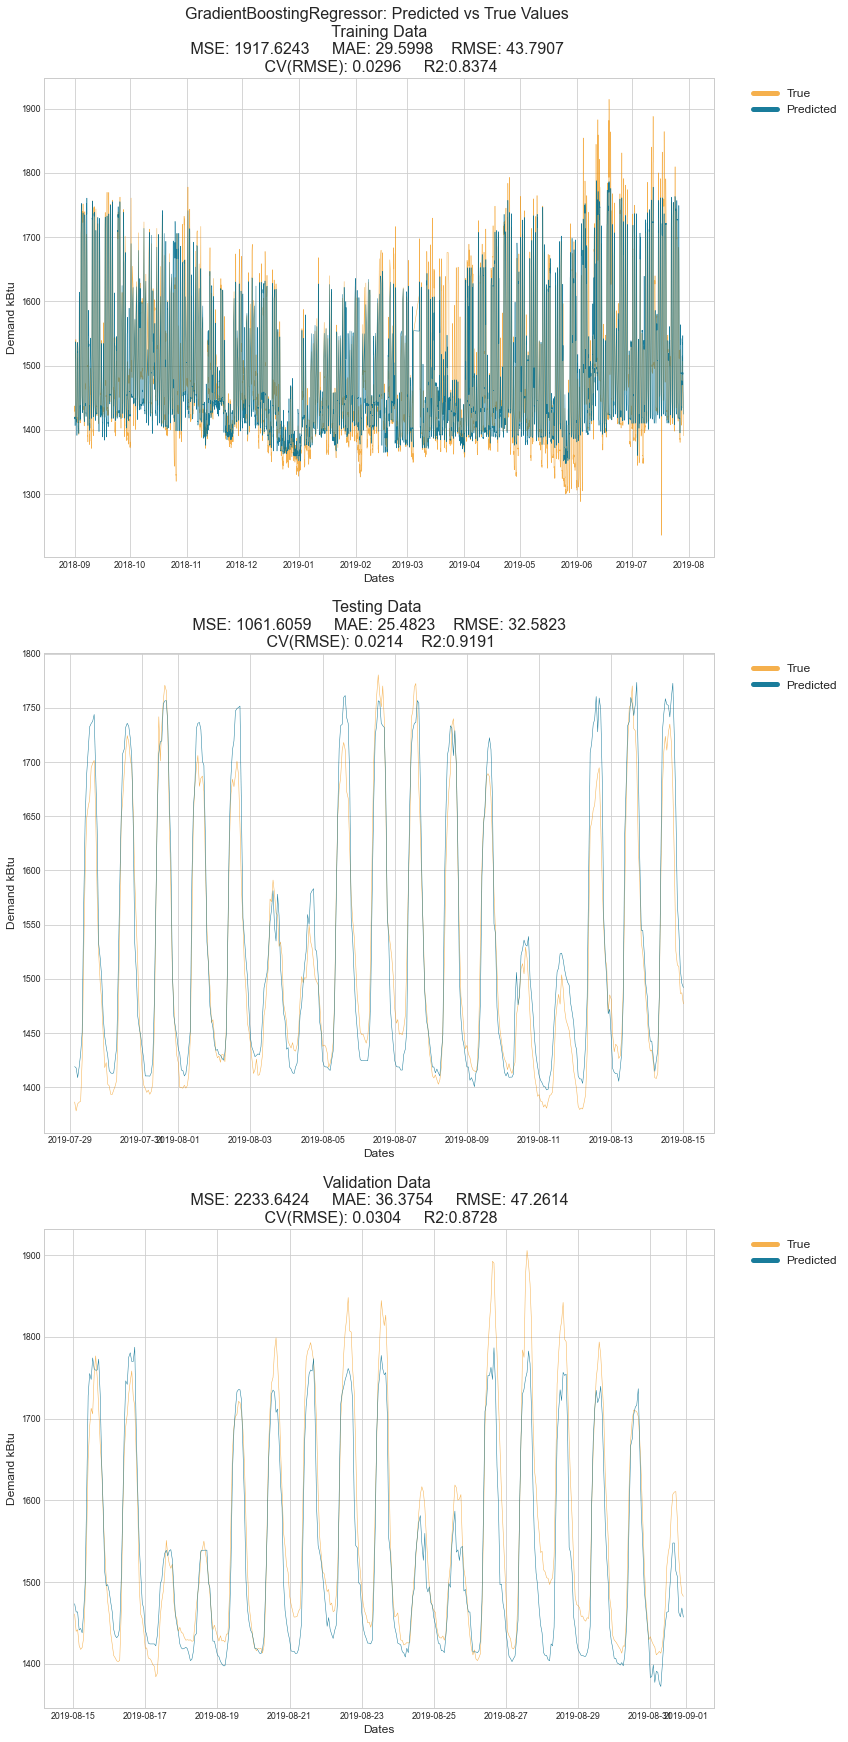

In [58]:
demandkBtu_model(tags) #takes about 30 seconds to run
